In [1]:
import pandas as pd
import numpy as np

In [2]:
data_all = pd.read_csv('Features_24048_ordered.csv')
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,ch,decorr_time,max_cross_corr_T8,max_cross_corr_P3,...,film,skewness,complexity_pe,Theta_watch-relax,max_cross_corr_O2,phase_lock_val_O2,time_corr_P8,complexity_hjorth,spect_corr_Cz,spect_corr_P7
0,1.596057,-0.554482,0.515982,3.861489,0.547128,0.284743,0,0.023438,0.786880,0.426773,...,1,0.009914,0.891923,2.799967,0.582575,0.451755,0.119249,1.503775,-0.318205,0.042403
1,1.747823,-0.403528,0.412857,3.410764,0.000000,0.289118,1,0.031250,0.673420,0.210159,...,1,-0.176532,0.898908,2.423711,0.234023,0.167281,-0.212034,1.580589,-0.284560,-0.051918
2,1.141897,-0.480005,0.543517,3.376908,0.350106,0.280260,2,0.031250,0.659345,0.079822,...,1,0.036370,0.909106,0.598116,0.158202,0.084936,0.179015,1.584523,0.434225,-0.065359
3,4.266919,-0.303031,0.389651,3.858740,0.493155,0.205972,3,0.031250,0.626992,0.152661,...,1,-0.064828,0.943144,2.463385,0.073971,0.042473,-0.269873,1.549235,0.705577,-0.610527
4,1.637947,0.164706,0.108198,3.347340,0.314772,0.313844,4,0.031250,0.517999,0.555728,...,1,0.069670,0.893920,2.877471,0.767190,0.663336,-0.043177,1.631652,-0.500022,0.274526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24043,0.000007,-0.099480,0.778112,3.720716,0.101662,0.545461,13,-1.000000,0.400011,0.684030,...,41,-0.090223,0.923568,-6.313633,0.381129,0.311370,-0.550802,3.156594,0.000000,-0.718118
24044,0.000007,0.460326,0.000000,3.763202,0.078970,0.470324,14,-1.000000,0.700749,0.535370,...,41,-0.091936,0.938375,-4.207895,0.408517,0.328050,0.085065,2.750451,0.619413,-0.630446
24045,0.000022,0.664151,0.700749,4.442161,0.058632,0.288971,15,-1.000000,0.000000,0.186501,...,41,-0.115286,0.972179,-1.109159,0.231259,0.184066,0.407111,2.096039,-0.719994,0.827614
24046,0.000009,0.661870,0.838547,3.851053,0.078919,0.479664,16,-1.000000,0.754653,0.309733,...,41,-0.107688,0.947336,-3.524445,0.157203,0.127064,-0.059322,2.917795,0.826933,-0.672841


## Посмотрим как обстоят дела с обучением на неотфильтрованной и немасштабированной выборке

In [2]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Ridge

In [3]:
from sklearn.neural_network import MLPRegressor

In [5]:
mlp = MLPRegressor()

In [9]:
X_test = data_all.loc[(data_all['film'] == 41)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 41)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'ch', 'Subj', 'labels'], axis=1)
X_test = X_test.drop(['film', 'ch', 'Subj', 'labels'], axis=1)

In [10]:
preds = MLPRegressor(random_state = 1).fit(X_train, y_train).predict(X_test)

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(8)] for i in range(42)]
num_chans = [[0 for j in range(8)] for i in range(42)]
labels = [[0 for j in range(8)] for i in range(42)]
lbl = [[0 for j in range(8)] for i in range(42)]
channels = [[] for i in range(40)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += 1
    labels[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(y_test)[i]
    channels[np.array(test_subj)[i]].append(chans[test_ch[i]])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(8):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [12]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 10.00 predicted: 5.97 
label : 10.00 predicted: 16.13 
label : 6.00 predicted: 13.28 
label : 8.00 predicted: 12.47 
label : 3.00 predicted: 1474.81 
label : 7.00 predicted: -46.49 
label : 9.00 predicted: 15.43 


## Все плохо 

Откроем данные с категориальными признаками

In [13]:
data_all = pd.read_csv('Features_no_filtering_ordered.csv')
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,Subj_34,Subj_35,Subj_36,Subj_37,Subj_38,Subj_39,labels,film,ch,Subj
0,1.116430e-04,0.218165,0.516112,0.363249,0.549476,0.279508,0.744318,0.788015,0.427071,0.295006,...,0.0,0.0,0.0,0.0,0.0,0.0,7.83,1,0,1
1,1.222589e-04,0.294963,0.412961,0.302930,0.000000,0.284011,0.750000,0.674391,0.210305,0.406826,...,0.0,0.0,0.0,0.0,0.0,0.0,7.83,1,1,1
2,7.987486e-05,0.256055,0.543653,0.298399,0.351609,0.274894,0.750000,0.660297,0.079877,0.553034,...,0.0,0.0,0.0,0.0,0.0,0.0,7.83,1,2,1
3,2.984681e-04,0.346090,0.389749,0.362881,0.495271,0.198436,0.750000,0.627896,0.152767,0.794022,...,0.0,0.0,0.0,0.0,0.0,0.0,7.83,1,3,1
4,1.145732e-04,0.584050,0.108225,0.294442,0.316123,0.309459,0.750000,0.518746,0.556116,0.409080,...,0.0,0.0,0.0,0.0,0.0,0.0,7.83,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24043,4.222781e-10,0.449646,0.778307,0.344409,0.102099,0.547843,0.000000,0.400588,0.684508,0.809331,...,0.0,0.0,0.0,0.0,0.0,1.0,9.00,41,13,39
24044,3.903128e-10,0.734446,0.000000,0.350095,0.079309,0.470511,0.000000,0.701760,0.535743,0.499011,...,0.0,0.0,0.0,0.0,0.0,1.0,9.00,41,14,39
24045,1.437144e-09,0.838142,0.700925,0.440958,0.058883,0.283860,0.000000,0.000000,0.186631,0.140640,...,0.0,0.0,0.0,0.0,0.0,1.0,9.00,41,15,39
24046,5.283381e-10,0.836981,0.838758,0.361852,0.079258,0.480124,0.000000,0.755741,0.309949,0.800837,...,0.0,0.0,0.0,0.0,0.0,1.0,9.00,41,16,39


In [15]:
X_test = data_all.loc[(data_all['film'] == 41)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 41)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test = X_test['labels']
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'ch', 'Subj', 'labels'], axis=1)
X_test = X_test.drop(['film', 'ch', 'Subj', 'labels'], axis=1)

In [16]:
preds = MLPRegressor(alpha=1000, max_iter=1000).fit(X_train, y_train).predict(X_test)

In [4]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [18]:
print('r2:', r2_score(y_test, preds))
print('MAPE:', mean_absolute_percentage_error(y_test, preds))
print('MAE : ', mean_absolute_error(y_test, preds))

r2: -0.7588493873386764
MAPE: 0.38741817232407877
MAE :  2.7503955549668344


In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(8)] for i in range(42)]
num_chans = [[0 for j in range(8)] for i in range(42)]
labels = [[0 for j in range(8)] for i in range(42)]
lbl = [[0 for j in range(8)] for i in range(42)]
channels = [[] for i in range(40)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += 1
    labels[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(y_test)[i]
    channels[np.array(test_subj)[i]].append(chans[test_ch[i]])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(8):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [20]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 10.00 predicted: 5.55 
label : 10.00 predicted: 5.55 
label : 6.00 predicted: 5.55 
label : 8.00 predicted: 5.55 
label : 3.00 predicted: 5.55 
label : 7.00 predicted: 5.55 
label : 9.00 predicted: 5.55 


In [21]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE:', mean_absolute_error(lbl ,predicted))

r2: -0.7588493750033165
MAPE: 0.3874181723240787
MAE: 2.7503955549668335


## Попробуем применить QuantileTransformer

In [5]:
from sklearn.preprocessing import QuantileTransformer

In [ ]:
X_test = data_all.loc[(data_all['film'] == 41)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 41)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'ch', 'Subj', 'labels'], axis=1)
X_test = X_test.drop(['film', 'ch', 'Subj', 'labels'], axis=1)

qt_train = QuantileTransformer(output_distribution='normal',
                         copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                         copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

In [24]:
model = MLPRegressor(random_state = 1).fit(X_train, np.array(y_train).reshape(-1))
y_pred = model.predict(X_test)

In [25]:
preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(8)] for i in range(42)]
num_chans = [[0 for j in range(8)] for i in range(42)]
labels = [[0 for j in range(8)] for i in range(42)]
lbl = [[0 for j in range(8)] for i in range(42)]
channels = [[] for i in range(40)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += 1
    labels[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i]].append(chans[test_ch[i]])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(8):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [27]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 10.00 predicted: 10.00 
label : 10.00 predicted: 10.00 
label : 6.00 predicted: 7.20 
label : 8.00 predicted: 8.44 
label : 3.00 predicted: 3.00 
label : 7.00 predicted: 8.16 
label : 9.00 predicted: 8.00 


In [28]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: 0.8944834296789682
MAPE: 0.07602547744743557
MAE :  0.5432608997515999


## Уже лучше

Посмотрим на выбросы во всем датасете

In [146]:
data_all = pd.read_csv('Features_24048_ordered.csv')
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,ch,decorr_time,max_cross_corr_T8,max_cross_corr_P3,...,film,skewness,complexity_pe,Theta_watch-relax,max_cross_corr_O2,phase_lock_val_O2,time_corr_P8,complexity_hjorth,spect_corr_Cz,spect_corr_P7
0,1.596057,-0.554482,0.515982,3.861489,0.547128,0.284743,0,0.023438,0.786880,0.426773,...,1,0.009914,0.891923,2.799967,0.582575,0.451755,0.119249,1.503775,-0.318205,0.042403
1,1.747823,-0.403528,0.412857,3.410764,0.000000,0.289118,1,0.031250,0.673420,0.210159,...,1,-0.176532,0.898908,2.423711,0.234023,0.167281,-0.212034,1.580589,-0.284560,-0.051918
2,1.141897,-0.480005,0.543517,3.376908,0.350106,0.280260,2,0.031250,0.659345,0.079822,...,1,0.036370,0.909106,0.598116,0.158202,0.084936,0.179015,1.584523,0.434225,-0.065359
3,4.266919,-0.303031,0.389651,3.858740,0.493155,0.205972,3,0.031250,0.626992,0.152661,...,1,-0.064828,0.943144,2.463385,0.073971,0.042473,-0.269873,1.549235,0.705577,-0.610527
4,1.637947,0.164706,0.108198,3.347340,0.314772,0.313844,4,0.031250,0.517999,0.555728,...,1,0.069670,0.893920,2.877471,0.767190,0.663336,-0.043177,1.631652,-0.500022,0.274526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24043,0.000007,-0.099480,0.778112,3.720716,0.101662,0.545461,13,-1.000000,0.400011,0.684030,...,41,-0.090223,0.923568,-6.313633,0.381129,0.311370,-0.550802,3.156594,0.000000,-0.718118
24044,0.000007,0.460326,0.000000,3.763202,0.078970,0.470324,14,-1.000000,0.700749,0.535370,...,41,-0.091936,0.938375,-4.207895,0.408517,0.328050,0.085065,2.750451,0.619413,-0.630446
24045,0.000022,0.664151,0.700749,4.442161,0.058632,0.288971,15,-1.000000,0.000000,0.186501,...,41,-0.115286,0.972179,-1.109159,0.231259,0.184066,0.407111,2.096039,-0.719994,0.827614
24046,0.000009,0.661870,0.838547,3.851053,0.078919,0.479664,16,-1.000000,0.754653,0.309733,...,41,-0.107688,0.947336,-3.524445,0.157203,0.127064,-0.059322,2.917795,0.826933,-0.672841


In [147]:
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D

In [148]:
data_ours = data_all[data_all['film'] > 40].reset_index(drop=True)
ours_info = data_ours[['ch', 'film', 'Subj', 'labels']].reset_index(drop=True)
data_ours = data_ours.drop(['ch', 'film', 'Subj', 'labels'], axis=1)

In [149]:
data_deap = data_all[data_all['film'] < 41].reset_index(drop=True)
deap_info = data_deap[['ch', 'film', 'Subj', 'labels']].reset_index(drop=True)
data_deap = data_deap.drop(['ch', 'film', 'Subj', 'labels'], axis=1)

In [151]:
to_model_columns=data_ours.columns
clf=IsolationForest(n_estimators=1000)
clf.fit(data_ours[to_model_columns])
pred = clf.predict(data_ours[to_model_columns])
data_ours['anomaly'] = pred
ours_info['anomaly'] = pred
outliers = data_ours.loc[data_ours['anomaly'] == -1]
outlier_index = list(outliers.index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(data_ours['anomaly'].value_counts())

 1    927
-1     81
Name: anomaly, dtype: int64


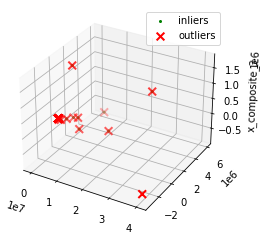

In [152]:
pca = PCA(n_components=3)
X_reduce = pca.fit_transform(data_ours)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index, 0],X_reduce[outlier_index, 1], X_reduce[outlier_index, 2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

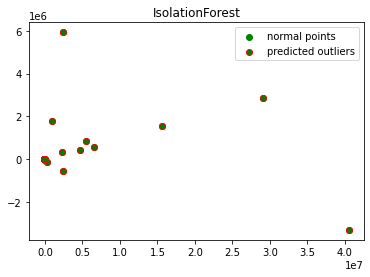

In [153]:
from sklearn.decomposition import PCA
pca = PCA(2)
pca.fit(data_ours[to_model_columns])
res=pd.DataFrame(pca.transform(data_ours[to_model_columns]))
Z = np.array(res)
plt.title("IsolationForest")
plt.contourf( Z, cmap=plt.cm.Blues_r)
b1 = plt.scatter(res[0], res[1], c='green', label="normal points")
b1 =plt.scatter(res.iloc[outlier_index,0],res.iloc[outlier_index,1], c='green',  edgecolor="red",label="predicted outliers")
plt.legend(loc="upper right")
plt.show()

In [154]:
to_model_columns=data_deap.columns
clf=IsolationForest(n_estimators=1000)
clf.fit(data_deap[to_model_columns])
pred = clf.predict(data_deap[to_model_columns])
data_deap['anomaly'] = pred
deap_info['anomaly'] = pred
outliers = data_deap.loc[data_deap['anomaly'] == -1]
outlier_index = list(outliers.index)
#Find the number of anomalies and normal points here points classified -1 are anomalous
print(data_deap['anomaly'].value_counts())

 1    20436
-1     2604
Name: anomaly, dtype: int64


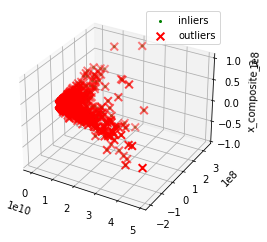

In [155]:
pca = PCA(n_components=3)
X_reduce = pca.fit_transform(data_deap)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.set_zlabel("x_composite_3")
# Plot the compressed data points
ax.scatter(X_reduce[:, 0], X_reduce[:, 1], zs=X_reduce[:, 2], s=4, lw=1, label="inliers",c="green")
# Plot x's for the ground truth outliers
ax.scatter(X_reduce[outlier_index, 0],X_reduce[outlier_index, 1], X_reduce[outlier_index, 2],
           lw=2, s=60, marker="x", c="red", label="outliers")
ax.legend()
plt.show()

In [156]:
data_deap = data_deap[data_deap['anomaly'] == 1]
data_deap

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,skewness,complexity_pe,Theta_watch-relax,max_cross_corr_O2,phase_lock_val_O2,time_corr_P8,complexity_hjorth,spect_corr_Cz,spect_corr_P7,anomaly
0,1.596057,-0.554482,0.515982,3.861489,0.547128,0.284743,0.023438,0.786880,0.426773,-0.407206,...,0.009914,0.891923,2.799967,0.582575,0.451755,0.119249,1.503775,-0.318205,0.042403,1
1,1.747823,-0.403528,0.412857,3.410764,0.000000,0.289118,0.031250,0.673420,0.210159,-0.184007,...,-0.176532,0.898908,2.423711,0.234023,0.167281,-0.212034,1.580589,-0.284560,-0.051918,1
2,1.141897,-0.480005,0.543517,3.376908,0.350106,0.280260,0.031250,0.659345,0.079822,0.107832,...,0.036370,0.909106,0.598116,0.158202,0.084936,0.179015,1.584523,0.434225,-0.065359,1
3,4.266919,-0.303031,0.389651,3.858740,0.493155,0.205972,0.031250,0.626992,0.152661,0.588857,...,-0.064828,0.943144,2.463385,0.073971,0.042473,-0.269873,1.549235,0.705577,-0.610527,1
4,1.637947,0.164706,0.108198,3.347340,0.314772,0.313844,0.031250,0.517999,0.555728,-0.179508,...,0.069670,0.893920,2.877471,0.767190,0.663336,-0.043177,1.631652,-0.500022,0.274526,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23035,14.114393,-0.136946,0.534528,3.409042,0.857950,0.335007,0.046875,0.754875,0.527393,-0.666923,...,0.141363,0.955954,-236.654488,0.253450,0.034874,0.447569,2.043562,0.000000,-0.565074,1
23036,47.204927,0.357077,0.000000,2.613139,0.252063,0.495519,0.046875,0.926856,0.852816,0.000000,...,0.663678,0.946769,-7715.896546,0.893938,0.667570,-0.354974,2.603108,-0.666923,0.351992,1
23037,6.868480,0.507137,0.926856,2.734533,0.617713,0.472632,0.046875,0.000000,0.868487,0.751350,...,0.486617,0.943928,-916.077611,0.688540,0.254580,-0.030282,2.490734,-0.605640,0.554440,1
23038,8.487236,0.001837,0.852352,2.931253,0.395563,0.425754,0.046875,0.838034,0.770769,0.581716,...,-0.256836,0.938336,-682.483971,0.712526,0.414198,-0.032179,2.303780,-0.324796,0.093403,1


In [157]:
data_ours = data_ours[data_ours['anomaly'] == 1]

## Очистим и склеим датасет, применив MinMaxScaler

In [158]:
from sklearn.preprocessing import MinMaxScaler

sc_deap = MinMaxScaler()
data_deap = pd.concat([pd.DataFrame(sc_deap.fit_transform(data_deap), columns=sc_deap.get_feature_names_out()).reset_index(drop=True), deap_info[deap_info['anomaly'] == 1].reset_index(drop=True)], axis=1).drop(['anomaly'], axis=1)
data_deap.index = [i for i in range(len(data_deap))]
sc_ours = MinMaxScaler()
data_ours = pd.concat([pd.DataFrame(sc_ours.fit_transform(data_ours), columns=sc_ours.get_feature_names_out()).reset_index(drop=True), ours_info[ours_info['anomaly'] == 1].reset_index(drop=True)], axis=1).drop(['anomaly'], axis=1)
data_ours.index = [i for i in range(len(data_deap), len(data_deap) + len(data_ours))]
data_all = pd.concat([data_deap, data_ours], axis=0)
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,max_cross_corr_O2,phase_lock_val_O2,time_corr_P8,complexity_hjorth,spect_corr_Cz,spect_corr_P7,ch,film,Subj,labels
0,0.002625,0.193831,0.517822,0.469241,0.559155,0.456579,0.2,0.788509,0.428117,0.290183,...,0.584519,0.468272,0.563673,0.208431,0.334153,0.518461,0,1,1,7.83
1,0.002977,0.274256,0.414329,0.365786,0.000000,0.464022,0.4,0.674814,0.210820,0.403302,...,0.234803,0.173397,0.389198,0.256358,0.351195,0.470890,1,1,1,7.83
2,0.001572,0.233510,0.545455,0.358015,0.357802,0.448952,0.4,0.660710,0.080073,0.551209,...,0.158730,0.088041,0.595149,0.258812,0.715261,0.464112,2,1,1,7.83
3,0.008818,0.327797,0.391040,0.468610,0.503995,0.322556,0.4,0.628290,0.153142,0.794997,...,0.074218,0.044026,0.358736,0.236795,0.852702,0.189161,3,1,1,7.83
4,0.002722,0.576995,0.108584,0.351228,0.321692,0.506091,0.4,0.519071,0.557478,0.405582,...,0.769750,0.687589,0.478129,0.288218,0.242063,0.635530,4,1,1,7.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21358,0.014841,0.492309,0.855602,0.366722,0.108974,0.558167,0.0,0.447101,0.694548,0.807045,...,0.389262,0.319753,0.023037,0.029479,0.499983,0.137655,13,41,39,9.00
21359,0.013717,0.840575,0.000000,0.374712,0.084650,0.479378,0.0,0.783243,0.543601,0.493005,...,0.417235,0.336882,0.466923,0.023734,0.809701,0.181660,14,41,39,9.00
21360,0.050507,0.967379,0.770535,0.502403,0.062848,0.289209,0.0,0.000000,0.189368,0.130337,...,0.236194,0.189021,0.691737,0.014477,0.139974,0.913488,15,41,39,9.00
21361,0.018568,0.965960,0.922056,0.391234,0.084595,0.489172,0.0,0.843492,0.314496,0.798449,...,0.160557,0.130484,0.366129,0.026101,0.913464,0.160381,16,41,39,9.00


In [159]:
data_all.to_csv('features_filtered_IsolationForest_1000.csv', index=False)

In [160]:
data_all = pd.read_csv('features_filtered_IsolationForest_1000.csv')
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,max_cross_corr_O2,phase_lock_val_O2,time_corr_P8,complexity_hjorth,spect_corr_Cz,spect_corr_P7,ch,film,Subj,labels
0,0.002625,0.193831,0.517822,0.469241,0.559155,0.456579,0.2,0.788509,0.428117,0.290183,...,0.584519,0.468272,0.563673,0.208431,0.334153,0.518461,0,1,1,7.83
1,0.002977,0.274256,0.414329,0.365786,0.000000,0.464022,0.4,0.674814,0.210820,0.403302,...,0.234803,0.173397,0.389198,0.256358,0.351195,0.470890,1,1,1,7.83
2,0.001572,0.233510,0.545455,0.358015,0.357802,0.448952,0.4,0.660710,0.080073,0.551209,...,0.158730,0.088041,0.595149,0.258812,0.715261,0.464112,2,1,1,7.83
3,0.008818,0.327797,0.391040,0.468610,0.503995,0.322556,0.4,0.628290,0.153142,0.794997,...,0.074218,0.044026,0.358736,0.236795,0.852702,0.189161,3,1,1,7.83
4,0.002722,0.576995,0.108584,0.351228,0.321692,0.506091,0.4,0.519071,0.557478,0.405582,...,0.769750,0.687589,0.478129,0.288218,0.242063,0.635530,4,1,1,7.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21358,0.014841,0.492309,0.855602,0.366722,0.108974,0.558167,0.0,0.447101,0.694548,0.807045,...,0.389262,0.319753,0.023037,0.029479,0.499983,0.137655,13,41,39,9.00
21359,0.013717,0.840575,0.000000,0.374712,0.084650,0.479378,0.0,0.783243,0.543601,0.493005,...,0.417235,0.336882,0.466923,0.023734,0.809701,0.181660,14,41,39,9.00
21360,0.050507,0.967379,0.770535,0.502403,0.062848,0.289209,0.0,0.000000,0.189368,0.130337,...,0.236194,0.189021,0.691737,0.014477,0.139974,0.913488,15,41,39,9.00
21361,0.018568,0.965960,0.922056,0.391234,0.084595,0.489172,0.0,0.843492,0.314496,0.798449,...,0.160557,0.130484,0.366129,0.026101,0.913464,0.160381,16,41,39,9.00


In [ ]:
X_test = data_all.loc[(data_all['film'] == 41)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 41)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'ch', 'Subj', 'labels'], axis=1)
X_test = X_test.drop(['film', 'ch', 'Subj', 'labels'], axis=1)

qt_train = QuantileTransformer(output_distribution='normal',
                         copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                         copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

In [ ]:
model = MLPRegressor(random_state = 1).fit(X_train, np.array(y_train).reshape(-1))
y_pred = model.predict(X_test)

In [107]:
preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(8)] for i in range(42)]
num_chans = [[0 for j in range(8)] for i in range(42)]
labels = [[0 for j in range(8)] for i in range(42)]
lbl = [[0 for j in range(8)] for i in range(42)]
channels = [[] for i in range(40)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += 1
    labels[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i]].append(chans[test_ch[i]])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(8):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])

In [109]:
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

label : 10.00 predicted: 9.57 
label : 10.00 predicted: 8.94 
label : 6.00 predicted: 7.73 
label : 8.00 predicted: 8.12 
label : 3.00 predicted: 5.03 
label : 7.00 predicted: 8.58 
label : 9.00 predicted: 8.78 


In [110]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: 0.7089244737636005
MAPE: 0.19705842362749348
MAE :  1.0247638973254547


## Закодируем категориальные признаки с помощью OneHotEncoder

In [111]:
from sklearn.preprocessing import OneHotEncoder

In [161]:
enc = OneHotEncoder(handle_unknown='ignore')

In [162]:
enc.fit(data_all[['film', 'ch', 'Subj']])
X_all_cat = pd.DataFrame(enc.transform(data_all[['film', 'ch', 'Subj']]).toarray(), columns=enc.get_feature_names_out(['film', 'ch', 'Subj']))
X_all_cat

,film_1,film_2,film_3,film_4,film_5,film_6,film_7,film_8,film_9,film_10,...,Subj_30,Subj_31,Subj_32,Subj_33,Subj_34,Subj_35,Subj_36,Subj_37,Subj_38,Subj_39
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21358,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21359,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21360,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21361,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [163]:
data_all = pd.concat([data_all, X_all_cat], axis=1)
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,Subj_30,Subj_31,Subj_32,Subj_33,Subj_34,Subj_35,Subj_36,Subj_37,Subj_38,Subj_39
0,0.002625,0.193831,0.517822,0.469241,0.559155,0.456579,0.2,0.788509,0.428117,0.290183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002977,0.274256,0.414329,0.365786,0.000000,0.464022,0.4,0.674814,0.210820,0.403302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001572,0.233510,0.545455,0.358015,0.357802,0.448952,0.4,0.660710,0.080073,0.551209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.008818,0.327797,0.391040,0.468610,0.503995,0.322556,0.4,0.628290,0.153142,0.794997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002722,0.576995,0.108584,0.351228,0.321692,0.506091,0.4,0.519071,0.557478,0.405582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21358,0.014841,0.492309,0.855602,0.366722,0.108974,0.558167,0.0,0.447101,0.694548,0.807045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21359,0.013717,0.840575,0.000000,0.374712,0.084650,0.479378,0.0,0.783243,0.543601,0.493005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21360,0.050507,0.967379,0.770535,0.502403,0.062848,0.289209,0.0,0.000000,0.189368,0.130337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21361,0.018568,0.965960,0.922056,0.391234,0.084595,0.489172,0.0,0.843492,0.314496,0.798449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [115]:
X_test = data_all.loc[(data_all['film'] == 41)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 41)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'ch', 'Subj', 'labels'], axis=1)
X_test = X_test.drop(['film', 'ch', 'Subj', 'labels'], axis=1)

qt_train = QuantileTransformer(output_distribution='normal',
                         copy=True)
y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
qt_test = QuantileTransformer(output_distribution='normal',
                         copy=True)
y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))

model = MLPRegressor(random_state = 1).fit(X_train, np.array(y_train).reshape(-1))
y_pred = model.predict(X_test)

preds = qt_test.inverse_transform(y_pred.reshape(-1, 1))


chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
pred = [[0 for j in range(8)] for i in range(42)]
num_chans = [[0 for j in range(8)] for i in range(42)]
labels = [[0 for j in range(8)] for i in range(42)]
lbl = [[0 for j in range(8)] for i in range(42)]
channels = [[] for i in range(40)]
for i in range(len(preds)):
    pred[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(preds)[i]
    num_chans[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += 1
    labels[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += np.array(y_test_inv)[i]
    channels[np.array(test_subj)[i]].append(chans[test_ch[i]])
labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
labels = np.nan_to_num(labels)
pred = np.nan_to_num(pred)
predicted = []
lbl = []
for i in range(len(labels)):
    if sum(labels[i]) != 0:
        for j in range(8):
            if labels[i][j] != 0:
                lbl.append(labels[i][j])  
                predicted.append(pred[i][j])
                
for [l, p] in zip(lbl, predicted):
    print('label : {:0.2f} predicted: {:0.2f} '.format(l, p))

C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (107). n_quantiles is set to n_samples.
  warnings.warn(


label : 10.00 predicted: 10.00 
label : 10.00 predicted: 10.00 
label : 6.00 predicted: 7.91 
label : 8.00 predicted: 8.00 
label : 3.00 predicted: 3.82 
label : 7.00 predicted: 7.14 
label : 9.00 predicted: 9.31 


<ipython-input-115-737a96ddd2bf>:42: RuntimeWarning: invalid value encountered in true_divide
  labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
<ipython-input-115-737a96ddd2bf>:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
<ipython-input-115-737a96ddd2bf>:43: RuntimeWarning: invalid value encountered in true_divide
  pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)


In [116]:
print('r2:', r2_score(lbl, predicted))
print('MAPE:', mean_absolute_percentage_error(lbl, predicted))
print('MAE : ', mean_absolute_error(lbl, predicted))

r2: 0.8820122193218419
MAPE: 0.09246165965999124
MAE :  0.45547290019445935


In [164]:
data_all.to_csv('features_tree_one_hot_n1000.csv', index=False)

## Улучшили MAE, Но другие метрики чуть уменьшились

Переберем все фильмы

In [12]:
data_all = pd.read_csv('features_tree_one_hot_n1000.csv')
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,Subj_30,Subj_31,Subj_32,Subj_33,Subj_34,Subj_35,Subj_36,Subj_37,Subj_38,Subj_39
0,0.002625,0.193831,0.517822,0.469241,0.559155,0.456579,0.2,0.788509,0.428117,0.290183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002977,0.274256,0.414329,0.365786,0.000000,0.464022,0.4,0.674814,0.210820,0.403302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001572,0.233510,0.545455,0.358015,0.357802,0.448952,0.4,0.660710,0.080073,0.551209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.008818,0.327797,0.391040,0.468610,0.503995,0.322556,0.4,0.628290,0.153142,0.794997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002722,0.576995,0.108584,0.351228,0.321692,0.506091,0.4,0.519071,0.557478,0.405582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21358,0.014841,0.492309,0.855602,0.366722,0.108974,0.558167,0.0,0.447101,0.694548,0.807045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21359,0.013717,0.840575,0.000000,0.374712,0.084650,0.479378,0.0,0.783243,0.543601,0.493005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21360,0.050507,0.967379,0.770535,0.502403,0.062848,0.289209,0.0,0.000000,0.189368,0.130337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21361,0.018568,0.965960,0.922056,0.391234,0.084595,0.489172,0.0,0.843492,0.314496,0.798449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [13]:
from tqdm import tqdm_notebook

In [14]:
models = ['MLPRegressor']
metrics = ['MAPE', 'MAE', 'R2']
formes = ['inverted', 'average']
columns = [
    np.array([models[i] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([metrics[j] for i in range(1) for j in range(3) for k in range(2)]),
    np.array([formes[k] for i in range(1) for j in range(3) for k in range(2)]),
]

In [15]:
columns

[array(['MLPRegressor', 'MLPRegressor', 'MLPRegressor', 'MLPRegressor',
        'MLPRegressor', 'MLPRegressor'], dtype='<U12'),
 array(['MAPE', 'MAPE', 'MAE', 'MAE', 'R2', 'R2'], dtype='<U4'),
 array(['inverted', 'average', 'inverted', 'average', 'inverted',
        'average'], dtype='<U8')]

In [16]:
import warnings
import logging
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("sclearn").setLevel(logging.WARNING)

In [17]:
import matplotlib.pyplot as plt

<ipython-input-12-6e2d53a7b0ff>:4: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for film in tqdm_notebook(range(41, 49)):


  0%|          | 0/8 [00:00<?, ?it/s]

C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (107). n_quantiles is set to n_samples.
  warnings.warn(
<ipython-input-12-6e2d53a7b0ff>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook([(500,300,100), (80, 60, 60, 60, 40, 40, 40, 40, 20, 10), (80, 60, 60, 40, 40, 40, 20, 10),


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y 

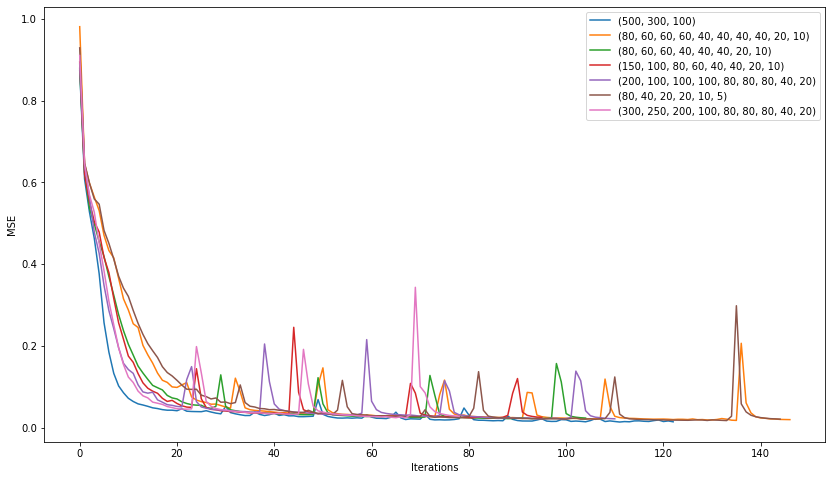

C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\preprocessing\_data.py:2590: UserWarning: n_quantiles (1000) is greater than the total number of samples (121). n_quantiles is set to n_samples.
  warnings.warn(
<ipython-input-12-6e2d53a7b0ff>:31: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i in tqdm_notebook([(500,300,100), (80, 60, 60, 60, 40, 40, 40, 40, 20, 10), (80, 60, 60, 40, 40, 40, 20, 10),


  0%|          | 0/7 [00:00<?, ?it/s]

C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
C:\Users\po6wi\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1599: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
for film in tqdm_notebook(range(41, 49)):
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test_inv = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    X_train = X_train.drop(['labels'], axis=1)
    X_test = X_test.drop(['labels'], axis=1)
    
    X_train = X_train.drop(['film', 'ch', 'Subj'], axis=1)
    X_test = X_test.drop(['film', 'ch', 'Subj'], axis=1)
    
    qt_train = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
    qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))
    plt.figure(figsize=(14, 8))
    for i in tqdm_notebook([(500,300,100), (80, 60, 60, 60, 40, 40, 40, 40, 20, 10), (80, 60, 60, 40, 40, 40, 20, 10),
              (150, 100, 80, 60, 40, 40, 20, 10), (200, 100, 100, 100, 80, 80, 80, 40, 20), (80, 40, 20, 20, 10, 5),
              (300, 250, 200, 100, 80, 80, 80, 40, 20)]):
        nn = MLPRegressor(random_state=17, hidden_layer_sizes=i, alpha=0.03, 
                          learning_rate='adaptive', learning_rate_init=0.001, max_iter=200, momentum=0.9, 
                          nesterovs_momentum=True)
        nn.fit(X_train, y_train)
        plt.plot(nn.loss_curve_, label=str(i));
    plt.xlabel('Iterations')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.show()

In [ ]:
chans = ['Fz', 'F3', 'F7','C3', 'T7', 'Pz', 'P3','P7', 'O1', 'Oz', 'O2','P4', 'P8', 'Cz','C4', 'T8', 'F4', 'F8']
result = pd.DataFrame()
grid_res = []
for film in tqdm_notebook(range(41, 49)):
    df = pd.DataFrame(np.random.randn(1, 1 * 3 * 2), columns=columns)
    X_test = data_all.loc[(data_all['film'] == film)].reset_index(drop=True)
    X_train = data_all.loc[(data_all['film'] != film)].reset_index(drop=True)
    X_train = X_train.sample(frac=1)
    X_test = X_test.sample(frac=1)

    y_train = X_train['labels']
    y_test_inv = np.array(X_test['labels'])
    train_film = X_train['film']
    train_subj = X_train['Subj']
    train_ch = X_train['ch']
    test_film = X_test['film']
    test_subj = X_test['Subj']
    test_ch = np.array(X_test['ch'])
    X_train = X_train.drop(['labels'], axis=1)
    X_test = X_test.drop(['labels'], axis=1)
    
    X_train = X_train.drop(['film', 'ch', 'Subj'], axis=1)
    X_test = X_test.drop(['film', 'ch', 'Subj'], axis=1)
    
    qt_train = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_train = pd.DataFrame(qt_train.fit_transform(np.array(y_train).reshape(-1, 1)))
    qt_test = QuantileTransformer(output_distribution='normal',
                             copy=True)
    y_test = pd.DataFrame(qt_test.fit_transform(np.array(y_test_inv).reshape(-1, 1)))
    

    model = MLPRegressor(random_state=17, hidden_layer_sizes=(500,300,100), alpha=0.03, 
                          learning_rate='adaptive', learning_rate_init=0.001, max_iter=200, momentum=0.9, 
                          nesterovs_momentum=True)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds = qt_test.inverse_transform(np.array(y_pred).reshape(-1, 1))
    df[('MLPRegressor', 'R2', 'inverted')] = r2_score(preds, y_test_inv)
    df[('MLPRegressor', 'MAPE', 'inverted')] = mean_absolute_percentage_error(preds, y_test_inv)
    df[('MLPRegressor', 'MAE', 'inverted')] = mean_absolute_error(preds, y_test_inv)
    
    pred = [[0 for j in range(8)] for i in range(42)]
    num_chans = [[0 for j in range(8)] for i in range(42)]
    labels = [[0 for j in range(8)] for i in range(42)]
    lbl = [[0 for j in range(8)] for i in range(42)]
    channels = [[] for i in range(40)]
    for i in range(len(preds)):
        pred[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += preds[i]
        num_chans[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += 1
        labels[np.array(test_subj)[i]][np.array(test_film)[i] - 41] += y_test_inv[i]
        channels[np.array(test_subj)[i]].append(chans[test_ch[i]])
    labels = np.array(labels).astype(np.float64) / np.array(num_chans).astype(np.float64)
    pred = np.array(pred).astype(np.float64) / np.array(num_chans).astype(np.float64)
    labels = np.nan_to_num(labels)
    pred = np.nan_to_num(pred)
    predicted = []
    lbl = []
    for i in range(len(labels)):
        if sum(labels[i]) != 0:
            for j in range(8):
                if labels[i][j] != 0:
                    lbl.append(labels[i][j])  
                    predicted.append(pred[i][j])

    df[('MLPRegressor', 'R2', 'average')] = r2_score(lbl, predicted)
    df[('MLPRegressor', 'MAPE', 'average')] = mean_absolute_percentage_error(lbl, predicted)
    df[('MLPRegressor', 'MAE', 'average')] = mean_absolute_error(lbl, predicted)
    result = pd.concat([result, df], axis=0)

  0%|          | 0/8 [00:00<?, ?it/s]

In [172]:
result.index = [i for i in range(1, 9)]

In [173]:
described = result.describe()
described

MLPRegressor                                                  
              MAPE                 MAE                  R2          
          inverted   average  inverted   average  inverted   average
count     8.000000  8.000000  8.000000  8.000000  8.000000  8.000000
mean      0.272039  0.408094  1.511019  1.543313 -0.250541 -0.075450
std       0.187626  0.298207  0.842673  0.907662  0.921124  0.952722
min       0.094521  0.109240  0.605387  0.590973 -1.658735 -1.939326
25%       0.133409  0.176837  0.982955  0.988827 -0.917784 -0.634168
50%       0.210763  0.305160  1.260360  1.267576  0.126038  0.289773
75%       0.369272  0.598729  1.774949  1.857483  0.405812  0.553769
max       0.580755  0.963762  2.945183  3.003756  0.731450  0.838780

In [174]:
writer = pd.ExcelWriter('MLPRegressor_described.xlsx', engine='xlsxwriter')
described.to_excel(writer, sheet_name='MLPRegressor_described')
writer.sheets['MLPRegressor_described'].set_row(3, None, None, {'hidden': True})
writer.save()
writer.close()

In [175]:
writer = pd.ExcelWriter('MLPRegressor.xlsx', engine='xlsxwriter')
result.to_excel(writer, sheet_name='MLPRegressor')
writer.sheets['MLPRegressor'].set_row(3, None, None, {'hidden': True})
writer.save()

In [176]:
writer.close()

## Интерпретация признаков с помощью библиотеки SHAP

In [6]:
data_all = pd.read_csv('features_tree_one_hot_n1000.csv')
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,Subj_30,Subj_31,Subj_32,Subj_33,Subj_34,Subj_35,Subj_36,Subj_37,Subj_38,Subj_39
0,0.002625,0.193831,0.517822,0.469241,0.559155,0.456579,0.2,0.788509,0.428117,0.290183,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.002977,0.274256,0.414329,0.365786,0.000000,0.464022,0.4,0.674814,0.210820,0.403302,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.001572,0.233510,0.545455,0.358015,0.357802,0.448952,0.4,0.660710,0.080073,0.551209,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.008818,0.327797,0.391040,0.468610,0.503995,0.322556,0.4,0.628290,0.153142,0.794997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.002722,0.576995,0.108584,0.351228,0.321692,0.506091,0.4,0.519071,0.557478,0.405582,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21358,0.014841,0.492309,0.855602,0.366722,0.108974,0.558167,0.0,0.447101,0.694548,0.807045,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21359,0.013717,0.840575,0.000000,0.374712,0.084650,0.479378,0.0,0.783243,0.543601,0.493005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21360,0.050507,0.967379,0.770535,0.502403,0.062848,0.289209,0.0,0.000000,0.189368,0.130337,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
21361,0.018568,0.965960,0.922056,0.391234,0.084595,0.489172,0.0,0.843492,0.314496,0.798449,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [7]:
reject = ['film_1', 'film_2', 'film_3', 'film_4', 'film_5', 'film_6',
       'film_7', 'film_8', 'film_9', 'film_10', 'film_11', 'film_12',
       'film_13', 'film_14', 'film_15', 'film_16', 'film_17', 'film_18',
       'film_19', 'film_20', 'film_21', 'film_22', 'film_23', 'film_24',
       'film_25', 'film_26', 'film_27', 'film_28', 'film_29', 'film_30',
       'film_31', 'film_32', 'film_33', 'film_34', 'film_35', 'film_36',
       'film_37', 'film_38', 'film_39', 'film_40', 'film_41', 'film_42',
       'film_43', 'film_44', 'film_45', 'film_46', 'film_47', 'film_48',
       'ch_0', 'ch_1', 'ch_2', 'ch_3', 'ch_4', 'ch_5', 'ch_6', 'ch_7',
       'ch_8', 'ch_9', 'ch_10', 'ch_11', 'ch_12', 'ch_13', 'ch_14',
       'ch_15', 'ch_16', 'ch_17', 'Subj_1', 'Subj_2', 'Subj_3', 'Subj_4',
       'Subj_5', 'Subj_6', 'Subj_7', 'Subj_8', 'Subj_9', 'Subj_10',
       'Subj_11', 'Subj_12', 'Subj_13', 'Subj_14', 'Subj_15', 'Subj_16',
       'Subj_17', 'Subj_18', 'Subj_19', 'Subj_20', 'Subj_21', 'Subj_22',
       'Subj_23', 'Subj_25', 'Subj_26', 'Subj_27', 'Subj_28',
       'Subj_29', 'Subj_30', 'Subj_31', 'Subj_32', 'Subj_33', 'Subj_34',
       'Subj_35', 'Subj_36', 'Subj_37', 'Subj_39',
       'Subj_24', 'Subj_38'
         ]

In [8]:
data_all = data_all.drop(reject, axis=1)
data_all

,teager_kaiser_energy_6mean,time_corr_F8,max_cross_corr_C4,fractal_katz,phase_lock_val_F3,fisher_information,decorr_time,max_cross_corr_T8,max_cross_corr_P3,spect_corr_C4,...,max_cross_corr_O2,phase_lock_val_O2,time_corr_P8,complexity_hjorth,spect_corr_Cz,spect_corr_P7,ch,film,Subj,labels
0,0.002625,0.193831,0.517822,0.469241,0.559155,0.456579,0.2,0.788509,0.428117,0.290183,...,0.584519,0.468272,0.563673,0.208431,0.334153,0.518461,0,1,1,7.83
1,0.002977,0.274256,0.414329,0.365786,0.000000,0.464022,0.4,0.674814,0.210820,0.403302,...,0.234803,0.173397,0.389198,0.256358,0.351195,0.470890,1,1,1,7.83
2,0.001572,0.233510,0.545455,0.358015,0.357802,0.448952,0.4,0.660710,0.080073,0.551209,...,0.158730,0.088041,0.595149,0.258812,0.715261,0.464112,2,1,1,7.83
3,0.008818,0.327797,0.391040,0.468610,0.503995,0.322556,0.4,0.628290,0.153142,0.794997,...,0.074218,0.044026,0.358736,0.236795,0.852702,0.189161,3,1,1,7.83
4,0.002722,0.576995,0.108584,0.351228,0.321692,0.506091,0.4,0.519071,0.557478,0.405582,...,0.769750,0.687589,0.478129,0.288218,0.242063,0.635530,4,1,1,7.83
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21358,0.014841,0.492309,0.855602,0.366722,0.108974,0.558167,0.0,0.447101,0.694548,0.807045,...,0.389262,0.319753,0.023037,0.029479,0.499983,0.137655,13,41,39,9.00
21359,0.013717,0.840575,0.000000,0.374712,0.084650,0.479378,0.0,0.783243,0.543601,0.493005,...,0.417235,0.336882,0.466923,0.023734,0.809701,0.181660,14,41,39,9.00
21360,0.050507,0.967379,0.770535,0.502403,0.062848,0.289209,0.0,0.000000,0.189368,0.130337,...,0.236194,0.189021,0.691737,0.014477,0.139974,0.913488,15,41,39,9.00
21361,0.018568,0.965960,0.922056,0.391234,0.084595,0.489172,0.0,0.843492,0.314496,0.798449,...,0.160557,0.130484,0.366129,0.026101,0.913464,0.160381,16,41,39,9.00


In [9]:
X_test = data_all.loc[(data_all['film'] == 41)].reset_index(drop=True)
X_train = data_all.loc[(data_all['film'] != 41)].reset_index(drop=True)
X_train = X_train.sample(frac=1)
X_test = X_test.sample(frac=1)

y_train = X_train['labels']
y_test_inv = np.array(X_test['labels'])
train_film = X_train['film']
train_subj = X_train['Subj']
train_ch = X_train['ch']
test_film = X_test['film']
test_subj = X_test['Subj']
test_ch = np.array(X_test['ch'])

X_train = X_train.drop(['film', 'ch', 'Subj', 'labels'], axis=1)
X_test = X_test.drop(['film', 'ch', 'Subj', 'labels'], axis=1)


In [10]:
model = MLPRegressor(random_state=1, max_iter=1000)
model.fit(X_train, y_train)

MLPRegressor(max_iter=1000, random_state=1)

In [11]:
import shap

In [39]:
%matplotlib qt

In [13]:
import warnings
import logging
warnings.filterwarnings('ignore')

logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)
logging.getLogger("shap").setLevel(logging.WARNING)

  0%|          | 0/107 [00:00<?, ?it/s]

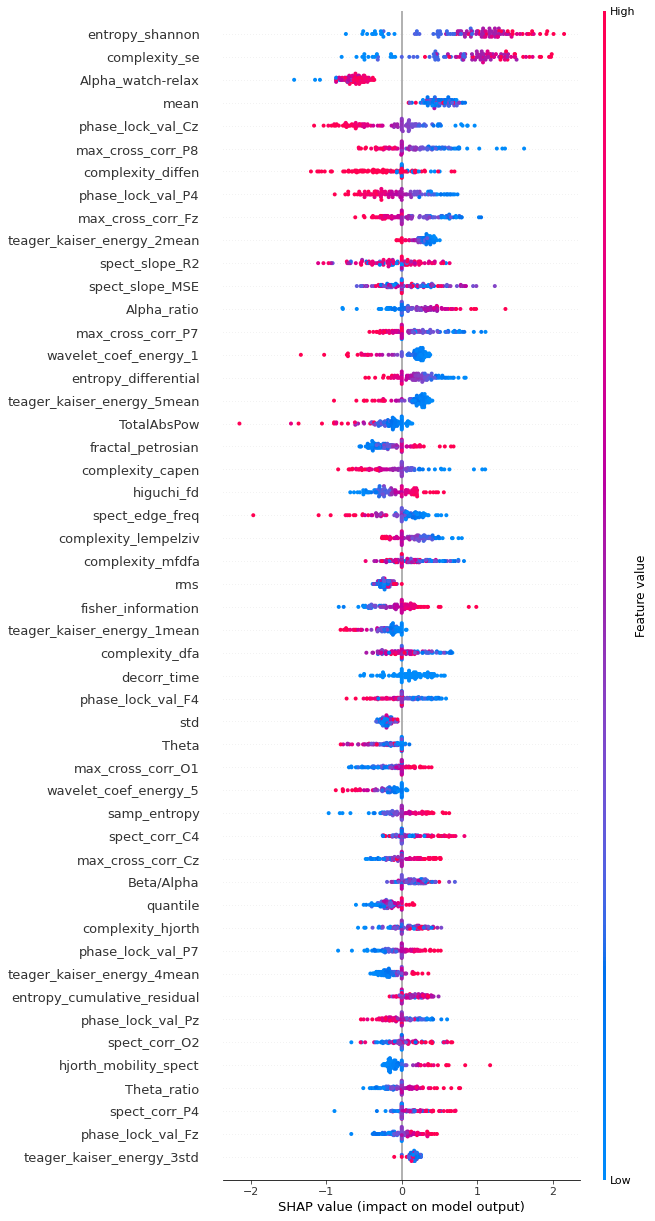

In [14]:
X_train_summary = shap.kmeans(X_train, 10)
explainer = shap.KernelExplainer(model.predict, X_train_summary)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, max_display=50)

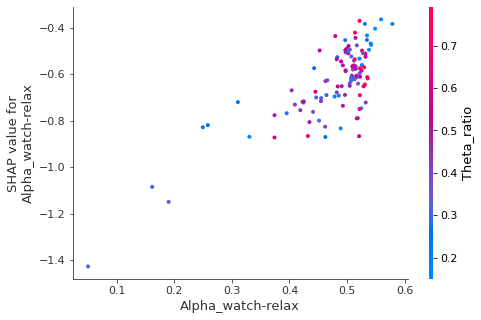

In [15]:
shap.dependence_plot("Alpha_watch-relax", shap_values, X_test)

In [16]:
shap.initjs()

In [17]:
shap.force_plot(explainer.expected_value, shap_values, X_test)